In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import os

In [2]:
filename = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname('treinamento.txt'))) + '/treinamento-1.txt'
series = pandas.read_csv(filename,  header=None)

In [3]:
def series_to_supervised(df, n_lags, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a pandas dataframe.
        n_lags: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = df.shape[1]
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lags, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pandas.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
D = series_to_supervised(series, 3).values

X = D[:,0:-1]
Y = D[:,-1].reshape(X.shape[0],1)

train_size = round(X.shape[0] * 0.7)
test_size = X.shape[0] - train_size
Xtr = X[0:train_size,:]
Xv = X[train_size:train_size+test_size,:]
Ytr = Y[0:train_size,:]
Yv = Y[train_size:train_size+test_size,:]

In [5]:
hidden_units=7

In [6]:
def sigmoid(Z):
    return 1 / (1+np.exp(-Z))

In [7]:
def calc_saida(X,Y,W1,W2,N):
    Z1 = np.dot(X,W1.T)
    ##tanh
    A1 = (np.exp(Z1) - np.exp(-Z1)) / (np.exp(Z1)+np.exp(-Z1))
    ##add bias
    A1 = np.concatenate((A1, np.ones((N,1))), axis=1)
    
    Z2 = np.dot(A1,W2.T)
    A2 = sigmoid(Z2)
    
    erro = A2 - Y
    
    return A1,A2,erro

In [8]:
def grad(X,Y,W1,W2,N):
    A1,A2,erro = calc_saida(X,Y,W1,W2,N)

    nh = W2.shape[1] - 1
    ns = Y.shape[1]
    
    dC_dAj = erro
    dAj_dZi = (A2 * (1 - A2))

    dC_Z2 =  dC_dAj * dAj_dZi
    
    dW2 = 1/N * np.dot((dC_Z2).T , A1)
    dW1 = 1/N * np.dot((np.dot(dC_Z2, W2[:,:nh]) * (1-(A1[:,:nh] * A1[:,:nh]))).T , X)
    return dW2, dW1

In [9]:
def perceptron(X,Y,alfa,nepocasmax,hidden_units):
    
    N = Y.shape[0]
    ns = Y.shape[1]
    nh = hidden_units

    ##add bias
    X = np.concatenate((X, np.ones((N,1))), axis=1)

    ne = X.shape[1]
    W1 = np.random.rand(nh,ne)/5
    W2 = np.random.rand(ns,nh+1)/5


    ##Calcula saida
    A1,A2,erro = calc_saida(X,Y,W1,W2,N)
    EQM = 1/N * np.sum(erro*erro)
    

    nval=0
    vet_erro = np.array([EQM])
    new_vet = vet_erro 
    nepocas=0
    alfa=1    
    
    while EQM>1e-4 and nepocas<nepocasmax:
        nepocas = nepocas + 1;
        dW2,dW1=grad(X,Y,W1,W2,N)
    
        W1 = W1 - (alfa * dW1)
        W2 = W2 - (alfa * dW2)

        A1,A2,erro = calc_saida(X,Y,W1,W2,N)
        EQM = 1/N * np.sum(erro*erro)
        new_vet = np.append(new_vet,EQM)

                
                
    plt.plot(new_vet)
    plt.ylabel('Error evolution')
    plt.show()

    return W1, W2, new_vet

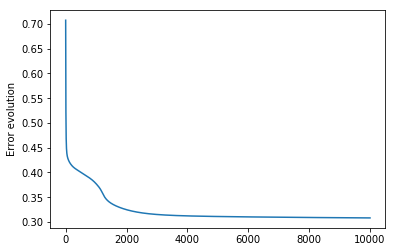

In [10]:
W1,W2,vet_erro=perceptron(Xtr,Ytr,0.2,10000,hidden_units)

In [11]:
vet_erro[-1]

0.30832142372871124

In [12]:
Nv = Yv.shape[0]

##add bias
Xv = np.concatenate((Xv, np.ones((Nv,1))), axis=1)

##Calcula saida
A1v,A2v,errov = calc_saida(Xv,Yv,W1,W2,Nv)
EQMv = 1/Nv * np.sum(errov*errov)

In [13]:
EQMv

0.2574010305781984

In [19]:
np.sum(A2v-Yv)/Nv

0.16797510907493038